In [191]:
# %load_ext autotime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from keras.layers import Add, Concatenate, Dense, Dropout
from keras import Input, losses, Model, optimizers, utils
from keras.metrics import MeanSquaredError, RootMeanSquaredError
import tensorflow as tf

from livelossplot import PlotLossesKeras
from datetime import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# from FUNCTIONS.evaluate import *

In [77]:
data_col_name = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

train_df = pd.read_csv('ml-100k/ua.base', sep='\t', names=data_col_name, encoding='latin-1')

test_df = pd.read_csv('ml-100k/ua.test', sep='\t', names=data_col_name, encoding='latin-1')

print(train_df.shape)
print(test_df.shape)

(90570, 4)
(9430, 4)


In [78]:
train_df.drop(columns="unix_timestamp", inplace=True)
test_df.drop(columns="unix_timestamp", inplace=True)

df = pd.concat([train_df, test_df], axis=0)
df

,user_id,movie_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3
...,...,...,...
9425,943,232,4
9426,943,356,4
9427,943,570,1
9428,943,808,4


In [4]:
print(df.shape)

(100000, 3)


In [5]:
df.nunique()

user_id      943
movie_id    1682
rating         5
dtype: int64

In [6]:
## ---------------------------------------------------------------- rating normalize
target_df = df['rating']
df['rating'] = (target_df - target_df.min()) / (target_df.max() - target_df.min())
df

,user_id,movie_id,rating
0,1,1,1.00
1,1,2,0.50
2,1,3,0.75
3,1,4,0.50
4,1,5,0.50
...,...,...,...
9425,943,232,0.75
9426,943,356,0.75
9427,943,570,0.00
9428,943,808,0.75


In [7]:
user_encoding = pd.get_dummies(df['user_id'])
user_encoding

,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9425,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9428,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
movie_encoding = pd.get_dummies(df['movie_id'])
movie_encoding

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9425,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9428,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [138]:
uX = user_encoding.to_numpy()
mX = movie_encoding.to_numpy()
uX

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [141]:
uX1 = uX[:train_df.shape[0]]
uX2 = uX[train_df.shape[0]:]
print(uX1.shape)
print(uX2.shape, '\n')

mX1 = mX[:train_df.shape[0]]
mX2 = mX[train_df.shape[0]:]
print(mX1.shape)
print(mX2.shape)


(90570, 943)
(9430, 943) 

(90570, 1682)
(9430, 1682)


In [9]:
X_df = pd.concat([user_encoding, movie_encoding], axis=1)
X_df

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9425,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9428,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
X = X_df.to_numpy()
X[:1]

array([[1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [11]:
X1 = X[:train_df.shape[0]]
X2 = X[train_df.shape[0]:]

print(X1.shape)
print(X2.shape)

(90570, 2625)
(9430, 2625)


In [12]:
Y = df['rating'].to_numpy()
Y

array([1.  , 0.5 , 0.75, ..., 0.  , 0.75, 0.25])

In [13]:
Y1 = Y[:train_df.shape[0]]
Y2 = Y[train_df.shape[0]:]

print(Y1.shape)
print(Y2.shape)

(90570,)
(9430,)


# MODEL

In [193]:
def make_inc():
    val = [0]
    def inc():
        val[0] += 1
        return val[0]
    return inc
inc = make_inc()

## -------------------------------------------------------------------------------- MODEL FUNCTION
f0, f1, f2, f3, f4, f5, f6, f7, f8 = 2, 4, 8, 12, 16, 20, 24, 28, 32
a0, a1, a2 = "relu", "swish", "selu"

def AE(x, target):
    lyr = [f8]
    for i in lyr[::-1]:
        x = Dense(i, activation=a2)(x)
    x = Dense(target, activation=a2)(x)
    # for i in lyr:
    #     x = Dense(i, activation=a0)(x)

    return x

# ## -------------------------------------------------------------------------------- MODEL
# input = Input(X1.shape[1])
# x = AE(input, 2)
# # output = Dense(X1.shape[1], activation=a0)(x)
# output = Dense(1, activation=a2)(x)
#
# model = Model(input, output)

## -------------------------------------------------------------------------------- MODEL 2
## ---------------------------------------------------------------- IN
u_input = Input(uX1.shape[1], name="u")
m_input = Input(mX1.shape[1], name="m")

## ---------------------------------------------------------------- BODY
u = AE(u_input, 3)
m = AE(m_input, 3)

# x = Concatenate(axis=1)([u, m])
x = Add()([u, m])

## ---------------------------------------------------------------- OUT
output = Dense(1, activation=a2, name="out")(x)

model = Model([u_input, m_input], output)

## -------------------------------------------------------------------------------- COMPILE
## ---------------------------------------------------------------- OPTIMIZER
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001,
                                                             decay_steps=100000,
                                                             decay_rate=0.96,
                                                             staircase=True)
# lr_schedule = k.optimizers.schedules.CosineDecay(initial_learning_rate=1e-4,
#                                                  decay_steps=EPOCH,)
optimizer = optimizers.Adam(learning_rate=lr_schedule)

# optimizer = optimizers.Adam(learning_rate=0.0001)

## ---------------------------------------------------------------- LOSS
# def adaptive_loss():
#     pass
# loss = losses.MeanAbsoluteError()
# loss = losses.BinaryCrossentropy()
loss = losses.MeanSquaredError()
# loss = losses.SparseCategoricalCrossentropy()
# loss = losses.BinaryFocalCrossentropy(alpha=0.25,
#                                       apply_class_balancing=False,
#                                       gamma=2.0,
#                                       from_logits=False,
#                                       label_smoothing=0.0,
#                                       axis=-1,
#                                       reduction=losses_utils.ReductionV2.AUTO,
#                                       name='binary_focal_crossentropy'
#                                       )
## ---------------------------------------------------------------- METRICS
# metrics = round(MeanSquaredError()**0.5, 4)
# metrics = [RootMeanSquaredError()]
# metrics = [SparseCategoricalAccuracy]
metrics = ['accuracy']

## ---------------------------------------------------------------- COMPILE
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()


Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 u (InputLayer)                 [(None, 943)]        0           []                               
                                                                                                  
 m (InputLayer)                 [(None, 1682)]       0           []                               
                                                                                                  
 dense_171 (Dense)              (None, 32)           30208       ['u[0][0]']                      
                                                                                                  
 dense_173 (Dense)              (None, 32)           53856       ['m[0][0]']                      
                                                                                           

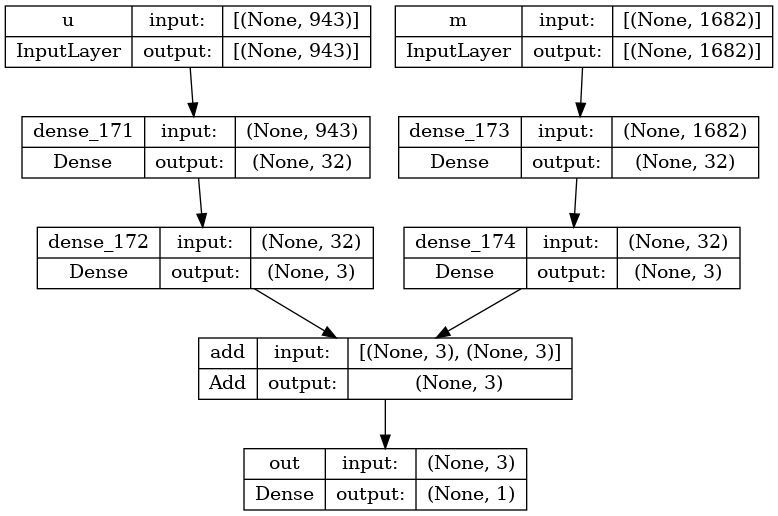

In [194]:
model_plot_save_name = f"model.png"
utils.plot_model(model, model_plot_save_name, show_shapes=True)

In [195]:
# from neuralplot import ModelPlot
#
# %matplotlib notebook
# modelplot = ModelPlot(model, grid=False, connection=True, linewidth=0.1)
# modelplot.show()

In [196]:
TIME = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}"
MODEL_VERSION = f"0.1"
SAVE_PATH = f"OUT/{MODEL_VERSION}"
MODEL_NAME = f"recommend"

## ---------------------------------------------------------------- INIT
EPOCH = 32
BATCH = 64
# ES = 4
ES = EPOCH//4

## ---------------------------------------------------------------- CALLBACK
earlyStop = EarlyStopping(patience=ES, monitor='val_loss', mode='auto', verbose=1)
tensorBoard = TensorBoard(log_dir=f"{SAVE_PATH}/log/{TIME}", histogram_freq=1)
checkPoint = ModelCheckpoint(f"{SAVE_PATH}/model/{TIME}_{MODEL_NAME}_ckpt.h5",  ## _{epoch:02d}-{val_loss:.2f},
                             save_best_only=True, verbose=1, save_freq='epoch',
                             monitor='val_accuracy',  ## 'loss', 'val_accuracy', 'val_loss'
                             mode='max')
history = model.fit({"u": uX1, "m": mX1},
                    {"out": Y1},
                    validation_split=0.05,
                    # validation_data=Y2,
                    batch_size=BATCH,
                    epochs=EPOCH,
                    use_multiprocessing=True,
                    verbose=1,
                    callbacks=[earlyStop,
                               tensorBoard,
                               checkPoint,
                               PlotLossesKeras(),
                               # PlotLossesKerasTF(),
                               ],
                    )

accuracy
	training         	 (min:    0.200, max:    0.246, cur:    0.246)
	validation       	 (min:    0.195, max:    0.211, cur:    0.211)
Loss
	training         	 (min:    0.053, max:    0.095, cur:    0.053)
	validation       	 (min:    0.065, max:    0.073, cur:    0.065)
1345/1345 [==============================] - 3s 2ms/step - loss: 0.0529 - accuracy: 0.2464 - val_loss: 0.0653 - val_accuracy: 0.2109


In [ ]:
for i in model.get_layer("dense_64").weights:
    print(i)


In [197]:
loss, acc = model.evaluate({"u": uX2, "m": mX2}, {"out": Y2}, verbose=1)

predict = model.predict({"u": uX2, "m": mX2})


295/295 [==============================] - 0s 790us/step


In [198]:
predict_0 = np.reshape(predict, predict.shape[0])
predict_0.shape

(9430,)

In [135]:
def v2_1_bias_finder(Y, P, start=-0.03, end=0.10, step=0.01):
    n = len(P)
    bias_num = n
    BIAS = 0
    F = 0
    pp_li = []
    for pp in np.arange(start, end, step):
        predict1 = P+pp
        for i in range(n):
            diff = abs(predict1[i]-Y[i])
            F += diff
        pp0 = round(pp, 2)
        pp_li.append((pp0, F))
        if bias_num > F:
            bias_num = F
            BIAS = pp0
        F = 0

    for i in pp_li:
        print(i)
    print()
    print(f"BIAS: {BIAS}")

    return BIAS


def v2_1_accuracy_calculator(Y, P, BIAS):
    predict_1 = P+BIAS
    n = len(P)
    wrong = 0
    Y2_cnt = 0
    # F_list = []
    for i in range(n):
        Y2_cnt += Y[i]
        diff = abs(predict_1[i]-Y[i])
        wrong += diff
        # F_list.append(diff[0])
    print(f"error: {wrong}")
    print(f"total: {Y2_cnt}")
    print(f"acc:   {round((Y2_cnt-wrong)/Y2_cnt, 2)*100}%")

In [136]:
BIAS = v2_1_bias_finder(Y2, predict_0, -0.10, 0.10, 0.01)

v2_1_accuracy_calculator(Y2, predict_0, BIAS)


(-0.1, 2069.578194104135)
(-0.09, 2032.7446608319879)
(-0.08, 1998.25254470855)
(-0.07, 1966.51890411973)
(-0.06, 1937.434556543827)
(-0.05, 1911.1915524117649)
(-0.04, 1887.9791056960821)
(-0.03, 1867.9589480627328)
(-0.02, 1850.7858771421015)
(-0.01, 1836.6167394556105)
(-0.0, 1825.600412093103)
(0.01, 1817.8271473702043)
(0.02, 1813.6320857517421)
(0.03, 1813.1754514686763)
(0.04, 1815.6223544701934)
(0.05, 1821.2695705965161)
(0.06, 1830.2856452353299)
(0.07, 1842.5086889490485)
(0.08, 1857.9531005695462)
(0.09, 1876.5662886574864)

BIAS: 0.03
error: 1813.1754514686763
total: 6100.75
acc:   70.0%


# RESULT VISUALIZE

In [178]:
def result_to_list(X, Y, P):
    result_list = []
    df1 = df.iloc[:, 0]
    n = len(X)
    for i in range(0, n, 1):
        user_id = df.iloc[train_df.shape[0]:, 0]
        movie_id = df.iloc[train_df.shape[0]:, 1]
        rP = round(P[i], 4)
        diff = round(abs(rP-Y[i]), 2)
        result_list.append([user_id[i], movie_id[i], Y[i], rP, diff])

    return result_list

result_list = result_to_list(X2, Y2, predict_0)

In [179]:
import csv

result_save_name = f"re1_result"

SAVE_CSV = 0
SAVE_TSV = 1

if SAVE_CSV == 1:
    with open(f"{result_save_name}.csv", 'w') as f:
        write = csv.writer(f)
        write.writerow(['user_id', 'movie_id', 'label', 'predict', 'difference'])
        write.writerows(result_list)

if SAVE_TSV == 1:
    with open(f"{result_save_name}.tsv", 'w', newline='') as f:
        write = csv.writer(f, delimiter='\t', lineterminator='\n')
        write.writerow(['user_id', 'movie_id', 'label', 'predict', 'difference'])
        write.writerows(result_list)
        # for record in SeqIO.parse("/home/fil/Desktop/420_2_03_074.fastq", "fastq"):
        #     write.writerow([record.id, record.seq, record.format("qual")])

In [199]:
## ---------------------------------------------------------------- CALC MSE
MSE = np.square(np.subtract(Y2, predict_0)).mean()
MSE

0.05888869355019758

In [223]:
def weight_visualizer(model, n1, n2):
    for i, l in enumerate(model.layers[n1:n2]):
        filters, biases = l.get_weights()
        print(l.name, filters.shape)

        fig = plt.figure(figsize=(8, 12))
        rows = int(round(np.sqrt(filters.shape[1])))
        columns = int(round(np.sqrt(filters.shape[1])))
        for i in range(1, columns*rows+1):
            # f = filters[:, :, :, i-1]
            fig = plt.subplot(rows, columns, i)
            fig.axis('off')
            # fig.set_xticks([])  # Turn off axis
            # fig.set_yticks([])
            plt.imshow(filters, cmap='gray')  # Show only the filters from 0th channel (R)
            # ix += 1
        plt.show()


weight_visualizer(model, 4, 7)

dense_172 (32, 3)


<IPython.core.display.Javascript object>

dense_174 (32, 3)


<IPython.core.display.Javascript object>

ValueError: not enough values to unpack (expected 2, got 0)

In [132]:
high_err_li = []
for i in result_list:
    if i[4] > 0.2:
        high_err_li.append(i)

err_csv_name = f"re1_err_result1.csv"
with open(err_csv_name, 'w') as f:
    write = csv.writer(f)
    write.writerow(['user_id', 'movie_id', 'label', 'predict', 'difference'])
    write.writerows(high_err_li)

# OTHER

In [ ]:
user_np = user_df.to_numpy()
print(user_np.shape)
print(user_np[:2])

In [ ]:
content_np = item_df.to_numpy()
print(content_np.shape)
print(content_np[:2])

In [ ]:
rating_np = train_df.to_numpy()
print(rating_np.shape)
print(rating_np[300:300+10])

In [ ]:
rating_np1 = test_df.to_numpy()
print(rating_np1.shape)
print(rating_np1[:10+10])

In [ ]:
rating_np1[0,2].dtype

# 상수 정의

In [ ]:
LATENT_SIZE = 2
BATCH_SIZE = 256

# User, Content, Score 클래스 정의

In [ ]:
import copy

In [ ]:
class User:
    def __init__(self, id, features):
        self.id = id
        self.features = features
        self.latent = np.random.random(LATENT_SIZE)

    def __str__(self):
        return f"id:{self.id}, features:{self.features}"

    def copy(self):
        return copy.deepcopy(self)  

    def is_same(self, other):
        return self.id == other.id

In [ ]:
class Content:
    def __init__(self, id, features):
        self.id = id
        self.features = features
        self.latent = np.random.random(LATENT_SIZE)

    def __str__(self):
        return f"id:{self.id}, features:{self.features}"

    def copy(self):
        return copy.deepcopy(self)  

    def is_same(self, other):
        return self.id == other.id

In [ ]:
class Score:
    def __init__(self, user, content, values):
        self.user = user
        self.content = content
        self.values = values

    def __str__(self):
        return f"user:{self.user.id}, content:{self.content.id}, values:{self.values}"

    def value(self):
        return self.values

    def copy(self):
        return copy.deepcopy(self)  

In [ ]:
id_2_user = {}
for i in range(len(user_np)):
    row = user_np[i]
    id = int(row[0])
    features = row[1:]
    user = User(id, features)
    id_2_user[id] = user

In [ ]:
id_2_content = {}
for i in range(len(content_np)):
    row = content_np[i]
    id = int(row[0])
    features = row[1:]
    content = Content(id, features)
    id_2_content[id] = content

In [ ]:
class Log:
    def __init__(self, raw_values):
        self.user_id = raw_values[0]
        self.content_id = raw_values[1]
        self.scores = raw_values[2:]

    def __str__(self):
        return f"user_id:{self.user_id}, content_id:{self.content_id}, scores:{self.scores}"

# User, Content, Score 객체 만들기

In [ ]:
scores = []
for i in range(len(rating_np)):
    log = Log(rating_np[i])
    user = id_2_user[log.user_id]
    content = id_2_content[log.content_id]
    score = Score(user.copy(), content.copy(), log.scores.copy())
    if(i<10): print(score)
    scores.append(score)

In [ ]:
print(f"user : {len(id_2_user)}")
print(f"content : {len(id_2_content)}")
print(f"scores : {len(scores)}")

# feature size

In [ ]:
SCORE_SIZE = len(scores[0].values)
USER_FEATURE_SIZE = len(scores[0].user.features)
CONTENT_FEATURE_SIZE = len(scores[0].content.features)
print(f"SCORE_SIZE : {SCORE_SIZE}")
print(f"USER_FEATURE_SIZE : {USER_FEATURE_SIZE}")
print(f"CONTENT_FEATURE_SIZE : {CONTENT_FEATURE_SIZE}")


# train, test 데이터 나누기

우선 섞고

In [ ]:
print(scores[:3])
np.random.shuffle(scores)
print(scores[:3])

In [ ]:
split_index = int(len(scores)*0.9)
train_scores, test_scores = scores[:split_index], scores[split_index:]

# 학습 데이터에 잡음 추가

In [ ]:
NOISE_RATIO = 0.0
for score in train_scores:
    if NOISE_RATIO==0.0: continue
    score.values += np.random.randn(SCORE_SIZE)*NOISE_RATIO
    score.values = score.values.clip(0.0, 1.0)


# 모델 정의

In [ ]:
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout, GaussianNoise
from tensorflow.keras.layers import Conv1D, Reshape, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
import tensorflow


f0, f1, f2, f3, f4, f5, f6, f7, f8 = 4, 8, 12, 16, 20, 24, 28, 32, 36
a0, a1 = "swish", "relu"


def layer(x):
    # x = Conv1D(f0, 3, activation='swish', input_shape=x.shape[1])(x)
    # x = Conv1D(f1, 3, activation='swish')(x)
    # x = Conv1D(f2, 3, activation='swish')(x)
    # x = Conv1D(f3, 3, activation='swish')(x)
    # x = Conv1D(f4, 3, activation='swish')(x)
    # x = Conv1D(f5, 3, activation='swish')(x)
    # x = Conv1D(f6, 3, activation='swish')(x)
    # x = Conv1D(f7, 3, activation='swish')(x)
    # x = Conv1D(f8, x.shaoe[0], activation='swish')(x)
    # x = Dense(f8, activation="swish")(x)
    # x = Dense(f7, activation="swish")(x)
    # x = Dense(f6, activation="swish")(x)
    # x = Dense(f5, activation="swish")(x)
    # x = Dense(f4, activation="swish")(x)
    x = Dense(f3, activation=a0)(x)
    x = Dense(f2, activation=a0)(x)
    x = Dense(f1, activation=a0)(x)

    return x


def build_encoder(name):
    latent_input = Input((LATENT_SIZE,))
    user_feature_input = Input((USER_FEATURE_SIZE,))
    content_feature_input = Input((CONTENT_FEATURE_SIZE,))
    score_input = Input((SCORE_SIZE,))
    #   score_input = GaussianNoise(0.3)(score_input)

    latent_x = Dense(6, activation=a0)(latent_input)
    user_feature_x = Dense(int(USER_FEATURE_SIZE/2), activation=a0)(user_feature_input)
    content_feature_x = Dense(int(CONTENT_FEATURE_SIZE/2), activation=a0)(content_feature_input)
    score_x = Dense(6, activation=a0)(score_input)

    x = concatenate([latent_x, user_feature_x, content_feature_x, score_x])
    print(x.shape)
    x = layer(x)
    latent = Dense(LATENT_SIZE, activation="sigmoid")(x)

    return Model((latent_input, user_feature_input, content_feature_input, score_input), latent, name=name)


def build_decoder(name):
    user_latent_input = Input((LATENT_SIZE,))
    user_feature_input = Input((USER_FEATURE_SIZE,))
    content_feature_input = Input((CONTENT_FEATURE_SIZE,))
    content_latent_input = Input((LATENT_SIZE,))

    user_latent_x = Dense(6, activation=a0)(user_latent_input)
    user_feature_x = Dense(int(USER_FEATURE_SIZE/2), activation=a0)(user_feature_input)
    content_feature_x = Dense(int(CONTENT_FEATURE_SIZE/2), activation=a0)(content_feature_input)
    content_lattent_x = Dense(6, activation=a0)(content_latent_input)

    x = concatenate([user_latent_x, user_feature_x, content_feature_x, content_lattent_x])
    x = layer(x)
    score_output = Dense(SCORE_SIZE, activation="sigmoid")(x)

    return Model((user_latent_input, user_feature_input, content_feature_input, content_latent_input), score_output, name=name)


decoder = build_decoder("D")


def build_user_input_autoencoder(name="UIAE"):
    encoder = build_encoder(f"{name}.E")

    user_latent = Input((LATENT_SIZE,))
    user_feature_input = Input((USER_FEATURE_SIZE,))
    content_feature_input = Input((CONTENT_FEATURE_SIZE,))
    score_input = Input((SCORE_SIZE,))

    content_latent = encoder((user_latent, user_feature_input, content_feature_input, score_input))
    score_output = decoder((user_latent, user_feature_input, content_feature_input, content_latent))
    autoencoder = Model((user_latent, user_feature_input, content_feature_input, score_input),
                        (content_latent, score_output), name=name)
    autoencoder.encoder = encoder
    autoencoder.decoder = decoder

    return autoencoder


def build_content_input_autoencoder(name="CIAE"):
    encoder = build_encoder(f"{name}.E")

    content_latent = Input((LATENT_SIZE,))
    user_feature_input = Input((USER_FEATURE_SIZE,))
    content_feature_input = Input((CONTENT_FEATURE_SIZE,))
    score_input = Input((SCORE_SIZE,))

    user_latent = encoder((content_latent, user_feature_input, content_feature_input, score_input))
    score_output = decoder((user_latent, user_feature_input, content_feature_input, content_latent))

    autoencoder = Model((content_latent, user_feature_input, content_feature_input, score_input),
                        (user_latent, score_output), name=name)
    autoencoder.encoder = encoder
    autoencoder.decoder = decoder

    return autoencoder


user_input_autoencoder = build_user_input_autoencoder("UIAE")

In [ ]:
from keras.optimizers.schedules.learning_rate_schedule import ExponentialDecay
from tensorflow.keras.optimizers import Adam, RMSprop


user_input_autoencoder = build_user_input_autoencoder("UIAE")
content_input_autoencoder = build_content_input_autoencoder("CIAE")

lr_schedule = ExponentialDecay(initial_learning_rate=0.0001,
                               decay_steps=100000,
                               decay_rate=0.96,
                               staircase=True)

autoencoder_optimizer = RMSprop(learning_rate=lr_schedule)
encoder_optimizer = RMSprop(learning_rate=lr_schedule)
decoder_optimizer = RMSprop(learning_rate=lr_schedule)

user_input_autoencoder.compile(loss="mse", optimizer=autoencoder_optimizer)
user_input_autoencoder.encoder.compile(loss="mse", optimizer=encoder_optimizer)
user_input_autoencoder.decoder.compile(loss="mse", optimizer=decoder_optimizer)

content_input_autoencoder.compile(loss="mse", optimizer=autoencoder_optimizer)
content_input_autoencoder.encoder.compile(loss="mse", optimizer=encoder_optimizer)
content_input_autoencoder.decoder.compile(loss="mse", optimizer=decoder_optimizer)


In [ ]:
from neuralplot import ModelPlot

target = content_input_autoencoder.encoder
%matplotlib notebook
modelplot = ModelPlot(target, grid=False, connection=True, linewidth=0.1)
modelplot.show()

In [ ]:
user_input_autoencoder.summary()
user_input_autoencoder.encoder.summary()
user_input_autoencoder.decoder.summary()

# 학습을 위한 데이터 생성 함수들 정의

In [ ]:
def build_user_input_autoencoder_data(scores):
    input_latents = np.array([score.user.latent for score in scores])
    user_features = np.array([score.user.features for score in scores])
    content_features = np.array([score.content.features for score in scores])
    input_scores = np.array([score.value() for score in scores])
    return input_latents, user_features, content_features, input_scores

def build_content_input_autoencoder_data(scores):
    input_latents = np.array([score.content.latent for score in scores])
    user_features = np.array([score.user.features for score in scores])
    content_features = np.array([score.content.features for score in scores])
    input_scores = np.array([score.value() for score in scores])
    return input_latents, user_features, content_features, input_scores


# train 데이터에는 없는 test 데이터 삭제

In [ ]:
content_id_2_scores = {}
user_id_2_scores = {}

for score in train_scores:
    content_id_2_scores[score.content.id] = []
    user_id_2_scores[score.user.id] = []

for score in train_scores:
    content_id_2_scores[score.content.id].append(score)
    user_id_2_scores[score.user.id].append(score)

content_ids = content_id_2_scores.keys()
user_ids = user_id_2_scores.keys()

to_be_removed_scores = set()
for score in test_scores:
    if score.content.id not in content_id_2_scores.keys():
        to_be_removed_scores.add(score)
    if score.user.id not in user_id_2_scores.keys():
        to_be_removed_scores.add(score)

print(f"{len(to_be_removed_scores)} scores removed in test_scores.")
for score in to_be_removed_scores:
    test_scores.remove(score)

# 사용자의 rating 수 파악

In [ ]:
user_id_2_scores = {}
for score in train_scores:
    user_id_2_scores[score.user.id] = []

for score in train_scores:
    user_id_2_scores[score.user.id].append(score)

l = [len(l) for l in user_id_2_scores.values()]
print(l)

In [ ]:
print(np.mean(l))

In [ ]:
plt.plot(l)
plt.show()

In [ ]:
plt.hist(l, bins=100)
plt.show()

# 학습 위한 함수

In [ ]:
def build_input_output(train_scores):
    size = len(train_scores)
    ul = np.empty((size, LATENT_SIZE))
    uf = np.empty((size, USER_FEATURE_SIZE))
    cf = np.empty((size, CONTENT_FEATURE_SIZE))
    cl = np.empty((size, LATENT_SIZE))
    s = np.empty((size, SCORE_SIZE))
    for i, score in enumerate(train_scores):
        ul[i] = score.user.latent
        uf[i] = score.user.features
        cf[i] = score.content.features
        cl[i] = score.content.latent
        s[i] = score.values
    return ul, uf, cf, cl, s

In [ ]:
LAMDA = 1.0

def build_content_id_2_latent(train_scores, content_latents):
    id_2_latents = {}
    for score in train_scores:
        id_2_latents[score.content.id] = []
    for score, content_latent in zip(train_scores, content_latents):
        id_2_latents[score.content.id].append(content_latent)
    id_2_latent = {}
    for id, latents in id_2_latents.items():
        id_2_latent[id] = np.mean(np.array(latents), axis=0)
    return id_2_latent

def build_user_id_2_latent(train_scores, user_latents):
    id_2_latents = {}
    for score in train_scores:
        id_2_latents[score.user.id] = []
    for score, user_latent in zip(train_scores, user_latents):
        id_2_latents[score.user.id].append(user_latent)
    id_2_latent = {}
    for id, latents in id_2_latents.items():
        id_2_latent[id] = np.mean(np.array(latents), axis=0)
    return id_2_latent

def update_content_latents_by_encoder(encoder, train_scores):
    user_latents, user_features, content_features, _, scores = build_input_output(train_scores)
    content_latents = encoder.predict((user_latents, user_features, content_features, scores), batch_size=BATCH_SIZE)
    id_2_latent = build_content_id_2_latent(train_scores, content_latents)
    for score in train_scores:
        score.content.latent = (1-LAMDA)*score.content.latent + LAMDA*id_2_latent[score.content.id]

def update_user_latents_by_encoder(encoder, train_scores):
    _, user_features, content_features, content_latents, scores = build_input_output(train_scores)
    user_latents = encoder.predict((content_latents, user_features, content_features, scores), batch_size=BATCH_SIZE)
    id_2_latent = build_user_id_2_latent(train_scores, user_latents)
    for score in train_scores:
        score.user.latent = (1-LAMDA)*score.user.latent + LAMDA*id_2_latent[score.user.id]


In [ ]:
from scipy.stats import gaussian_kde
import seaborn as sns


def update_test_score_latents_with_train_scores(train_scores, test_scores):

    user_id_2_latents = {}
    content_id_2_latents = {}
    for score in train_scores:
        user_id_2_latents[score.user.id] = []
        content_id_2_latents[score.content.id] = []

    for score in train_scores:
        user_id_2_latents[score.user.id].append(score.user.latent)
        content_id_2_latents[score.content.id].append(score.content.latent)

    user_id_2_latent = {}
    content_id_2_latent = {}

    def get_mean_latent(latents):
        return np.mean(np.array(latents), axis=0)

    for id in user_id_2_latents.keys():
        user_id_2_latent[id] = get_mean_latent(user_id_2_latents[id])
    for id in content_id_2_latents.keys():
        content_id_2_latent[id] = get_mean_latent(content_id_2_latents[id])

    for score in test_scores:
        score.user.latent = user_id_2_latent[score.user.id]
        score.content.latent = content_id_2_latent[score.content.id]

In [ ]:

def evaluate(train_scores, test_scores):

    ul, uf, cf, cl, true_scores = build_input_output(train_scores)
    predicted_scores = user_input_autoencoder.decoder.predict((ul, uf, cf, cl), batch_size=BATCH_SIZE)
    mse = mean_squared_error((true_scores*SCORE_DIFF+SCORE_MIN), (predicted_scores*SCORE_DIFF+SCORE_MIN))
    train_rmse = round(mse**0.5, 4)


    update_test_score_latents_with_train_scores(train_scores, test_scores)

    ul, uf, cf, cl, true_scores = build_input_output(test_scores)
    predicted_scores = user_input_autoencoder.decoder.predict((ul, uf, cf, cl), batch_size=BATCH_SIZE)
    mse = mean_squared_error((true_scores*SCORE_DIFF+SCORE_MIN), (predicted_scores*SCORE_DIFF+SCORE_MIN))
    test_rmse = round(mse**0.5, 4)  

    return train_rmse, test_rmse

In [ ]:
class Logger():
    def __init__(self):
        self.key_2_list = {}

    def _prepare_list(self, key):
        if key not in self.key_2_list.keys():
            self.key_2_list[key] = []

    def append(self, keras_history):
        for key in keras_history.history.keys():
            self._prepare_list(key)
            self.key_2_list[key].append(keras_history.history[key][-1])

    def __getitem__(self, key):
        return self.key_2_list[key]


In [ ]:
def update_score_latent_with_encoders(uie, cie, iter_count, train_scores):
    for i in range(iter_count):
        ul, uf, cf, cl, s = build_input_output(train_scores)
        predicted_cl = uie.predict((ul, uf, cf, s), batch_size=BATCH_SIZE)
        predicted_ul = cie.predict((cl, uf, cf, s), batch_size=BATCH_SIZE)

        for score, ul, cl in zip(train_scores, predicted_ul, predicted_cl):
            score.user.latent = ul
            score.content.latent = cl


In [ ]:
sample_user_id = 1
scores_of_sample_user = [score for score in train_scores if score.user.id==sample_user_id]

def draw_user_latent_distribution(scores):
    sample_user_latents = np.array([score.user.latent for score in scores])
    plt.scatter(sample_user_latents[:,0], sample_user_latents[:,1])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()
draw_user_latent_distribution(scores_of_sample_user)    

# 학습 실행

In [ ]:
EPOCH = 48

user_input_autoencoder.encoder.trainable = True
user_input_autoencoder.decoder.trainable = True
content_input_autoencoder.encoder.trainable = True
content_input_autoencoder.decoder.trainable = True

train_rmses = []
test_rmses = []
logger1 = Logger()
logger2 = Logger()

draw_user_latent_distribution(scores_of_sample_user)
for epoch in range(EPOCH):
    print(f"{epoch}/{EPOCH}")
    np.random.shuffle(train_scores)

    ul, uf, cf, cl, s = build_input_output(train_scores)
    autoencoder1_hist = user_input_autoencoder.fit((ul, uf, cf, s), (cl, s),
                                                   epochs=1,
                                                   batch_size=BATCH_SIZE,
                                                   validation_split=0.1)
    update_content_latents_by_encoder(user_input_autoencoder.encoder, train_scores)

    ul, uf, cf, cl, s = build_input_output(train_scores)
    autoencoder2_hist = content_input_autoencoder.fit((cl, uf, cf, s), (ul, s),
                                                      epochs=1,
                                                      batch_size=BATCH_SIZE,
                                                      validation_split=0.1)
    update_user_latents_by_encoder(content_input_autoencoder.encoder, train_scores)

    train_rmse, test_rmse = evaluate(train_scores, test_scores)
    print(f"train_rmse={train_rmse}, test_rmse={test_rmse}, diff={round(test_rmse-train_rmse, 5)}")
    draw_user_latent_distribution(scores_of_sample_user)

    logger1.append(autoencoder1_hist)
    logger2.append(autoencoder2_hist)

    train_rmses.append(train_rmse)
    test_rmses.append(test_rmse)


In [ ]:
def show_total_loss(logger1, logger2):
    print("total loss")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(logger1['loss'])

    plt.subplot(1, 2, 2)
    plt.plot(logger2['loss'])

    plt.show()

    print(round(logger1['loss'][-1], 5), round(logger2['loss'][-1], 5))
    print()


def show_latent_loss(logger1, logger2):
    print("latent loss")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(logger1['UIAE.E_loss'])

    plt.subplot(1, 2, 2)
    plt.plot(logger2['CIAE.E_loss'])

    plt.show()

    print(round(logger1['UIAE.E_loss'][-1], 5), round(logger2['CIAE.E_loss'][-1], 5))
    print()


def show_score_loss(logger1, logger2):
    print("score loss")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(logger1['D_loss'])

    plt.subplot(1, 2, 2)
    plt.plot(logger2['D_loss'])

    plt.show()

    print(round(logger1['D_loss'][-1], 5), round(logger2['D_loss'][-1], 5))
    print()


def show_rmse(train_rmses, test_rmses):
    print("RMSE")
    plt.plot(train_rmses, label="train rmse")
    plt.plot(test_rmses, label="test rmse")
    plt.legend()
    plt.show()

    print(f"train_rmse={round(train_rmses[-1], 5)}, test_rmse={round(test_rmses[-1], 5)}")
    print()


def show_loss(logger1, logger2, train_rmses, test_rmses):
    show_total_loss(logger1, logger2)
    show_latent_loss(logger1, logger2)
    show_score_loss(logger1, logger2)
    show_rmse(train_rmses, test_rmses)

In [ ]:
show_loss(logger1, logger2, train_rmses, test_rmses)

# 학습 결과 살펴보기

## AE의 입력으로 구한 score

In [ ]:
ul, uf, cf, cl, s = build_input_output(train_scores)
predicted_latents, predicted_scores = user_input_autoencoder.predict((ul, uf, cf, s),
                                                                     batch_size=BATCH_SIZE)

mse = mean_squared_error(s, predicted_scores)
print(mse)

## encoder의 출력을 decoder 입력으로 구한 score

In [ ]:
predicted_cl = user_input_autoencoder.encoder.predict((ul, uf, cf, s), batch_size=BATCH_SIZE)
predicted_scores = user_input_autoencoder.decoder.predict((ul, uf, cf, predicted_cl), batch_size=BATCH_SIZE)

mse = mean_squared_error(s, predicted_scores)
print(mse)

## train data로 직접 decoder로 구한 score

In [ ]:
predicted_scores = user_input_autoencoder.decoder.predict((ul, uf, cf, cl), batch_size=BATCH_SIZE)

mse = mean_squared_error(s, predicted_scores)
print(mse)

## train data 담긴 한 유저의 latent

In [ ]:
scores_of_user_id_1 = user_id_2_scores[1]
print(np.array([ score.user.latent for score in scores_of_user_id_1])[:5])

## encoder로 구한 한 유저의 latent

In [ ]:
ul, uf, cf, cl, s = build_input_output(scores_of_user_id_1)
predicted_user_latents = content_input_autoencoder.encoder.predict((cl, uf, cf, s), batch_size=BATCH_SIZE)

print(predicted_user_latents[:5])

In [ ]:
print(np.std(predicted_user_latents, axis=0))

In [ ]:
plt.subplot(1,2,1)
plt.hist(predicted_user_latents[:,0])
plt.subplot(1,2,2)
plt.hist(predicted_user_latents[:,1])
plt.show()
print("latent variation width :", np.max(predicted_user_latents, axis=0)-np.min(predicted_user_latents, axis=0))

In [ ]:
from sklearn.metrics import mean_squared_error

SCORE_NAMES = ["rating", "dummy1", "dummy2", "dummy3", "dummy4"]
def show_regression_result(train_or_test, true_scores, predicted_scores):

    print(f"{train_or_test} Data")
    print("true_score : predicted_score")
    plt.figure(figsize=(SCORE_SIZE*4, 3))
    for i in range(SCORE_SIZE):
        plt.subplot(1,SCORE_SIZE,i+1)
        plt.scatter(true_scores[:,i], predicted_scores[:,i], marker='.')
        plt.xlim((0.0, 1.0))
        plt.ylim((0.0, 1.0))
        plt.title(f'{SCORE_NAMES[i]}')
        plt.xlabel('truth')
        plt.ylabel('predicted')
    plt.show()

    # mse = mean_squared_error(true_scores, predicted_scores)
    # print("mse :",mse)
    # rmse = mse**0.5
    # print("rmse :",rmse)

    mse = mean_squared_error((true_scores*SCORE_DIFF+SCORE_MIN), (predicted_scores*SCORE_DIFF+SCORE_MIN))
    # print("mse :",mse)
    rmse = mse**0.5
    print("rmse :",rmse)


In [ ]:
ul, uf, cf, cl, s = build_input_output(train_scores)
predicted_scores = user_input_autoencoder.decoder.predict((ul, uf, cf, cl), batch_size=BATCH_SIZE)

In [ ]:
show_regression_result("Train", s, predicted_scores)

In [ ]:
update_test_score_latents_with_train_scores(train_scores, test_scores)
ul, uf, cf, cl, s = build_input_output(test_scores)
predicted_scores = user_input_autoencoder.decoder.predict((ul, uf, cf, cl), batch_size=BATCH_SIZE)


In [ ]:
show_regression_result("Test", s, predicted_scores)

# Decoder 추가 학습

# 학습 실행

In [ ]:
EPOCH = 10

from tensorflow.keras.optimizers import Adam, RMSprop
decoder_optimizer = RMSprop(learning_rate=0.001*0.1)
user_input_autoencoder.decoder.compile(loss="mse", optimizer=decoder_optimizer)


train_rmses = []
test_rmses = []
logger1 = Logger()
logger2 = Logger()

ul, uf, cf, cl, s = build_input_output(train_scores)

for epoch in range(EPOCH):
    print(f"{epoch}/{EPOCH}")

    autoencoder1_hist = user_input_autoencoder.decoder.fit((ul, uf, cf, cl), s,
        epochs=1, batch_size=BATCH_SIZE, validation_split=0.1)        

    train_rmse, test_rmse = evaluate(train_scores, test_scores)
    print(f"train_rmse={train_rmse}, test_rmse={test_rmse}, diff={round(test_rmse-train_rmse,5)}")

    train_rmses.append(train_rmse)
    test_rmses.append(test_rmse)


In [ ]:
show_rmse(train_rmses, test_rmses)

# 학습 결과 살펴보기

## AE의 입력으로 구한 score

In [ ]:
ul, uf, cf, cl, s = build_input_output(train_scores)
predicted_latents, predicted_scores = user_input_autoencoder.predict((ul, uf, cf, s), batch_size=BATCH_SIZE)        

mse = mean_squared_error(s, predicted_scores)
print(mse)

## encoder의 출력을 decoder 입력으로 구한 score

In [ ]:
predicted_cl = user_input_autoencoder.encoder.predict((ul, uf, cf, s), batch_size=BATCH_SIZE)
predicted_scores = user_input_autoencoder.decoder.predict((ul, uf, cf, predicted_cl), batch_size=BATCH_SIZE)

mse = mean_squared_error(s, predicted_scores)
print(mse)

## train data로 직접 decoder로 구한 score

In [ ]:
predicted_scores = user_input_autoencoder.decoder.predict((ul, uf, cf, cl), batch_size=BATCH_SIZE)

mse = mean_squared_error(s, predicted_scores)
print(mse)

## train data 담긴 한 유저의 latent

In [ ]:
scores_of_user_id_1 = user_id_2_scores[1]
print(np.array([ score.user.latent for score in scores_of_user_id_1])[:5])

## encoder로 구한 한 유저의 latent

In [ ]:
ul, uf, cf, cl, s = build_input_output(scores_of_user_id_1)
predicted_user_latents = content_input_autoencoder.encoder.predict((cl, uf, cf, s), batch_size=BATCH_SIZE)

print(predicted_user_latents[:5])

In [ ]:
print(np.std(predicted_user_latents, axis=0))

In [ ]:
plt.subplot(1,2,1)
plt.hist(predicted_user_latents[:,0])
plt.subplot(1,2,2)
plt.hist(predicted_user_latents[:,1])
plt.show()
print("latent variation width :", np.max(predicted_user_latents, axis=0)-np.min(predicted_user_latents, axis=0))

In [ ]:
ul, uf, cf, cl, s = build_input_output(train_scores)
predicted_scores = user_input_autoencoder.decoder.predict((ul, uf, cf, cl))

In [ ]:
show_regression_result("Train", s, predicted_scores)

In [ ]:
update_test_score_latents_with_train_scores(train_scores, test_scores)
ul, uf, cf, cl, s = build_input_output(test_scores)
predicted_scores = user_input_autoencoder.decoder.predict((ul, uf, cf, cl))


In [ ]:
show_regression_result("Test", s, predicted_scores)

# 좀 살펴보기

In [ ]:
target_index = -1
for i in range(1000):
    if s[i]==0.5:
        target_index = i
        break
print(target_index)
print(s[target_index])

In [ ]:
user_latents, user_features, content_features, content_latents, scores = build_input_output(train_scores)

target_index = -1
for i in range(1000):
    if scores[i][0]==0.5:
        target_index = i
        break
print(f"target_index={target_index}")
print(scores[target_index])


ul = np.empty((100*100, LATENT_SIZE))
uf = np.empty((100*100, USER_FEATURE_SIZE))
cf = np.empty((100*100, CONTENT_FEATURE_SIZE))
cl = np.empty((100*100, LATENT_SIZE))

for i in range(100):
    for j in range(100):
        ul[i*100+j] = user_latents[target_index]
        uf[i*100+j] = user_features[target_index]
        cf[i*100+j] = content_features[target_index]
        cl[i*100+j] = np.array([i*0.01,j*0.01])

ps = user_input_autoencoder.decoder.predict((ul, uf, cf, cl), batch_size=BATCH_SIZE)
print("predicted score")
plt.plot(ps)
plt.show()
print()

ps = np.abs(ps - s[target_index])
print("diff")
plt.plot(ps)
plt.show()
print()

hm = ps.reshape((100,100))
print("diff heatmap")
plt.pcolor(hm)
plt.show()

In [ ]:
target_user_id = train_scores[target_index].user.id
print(f"target_user_id={target_user_id}")

scores_of_target_user_id = [score for score in train_scores if score.user.id==target_user_id]
print(len(scores_of_target_user_id))

uls = np.array([score.user.latent for score in scores_of_target_user_id])
plt.scatter(uls[:,0], uls[:,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()


0.5 스코어를 보인 특정 user가 포함된 score들에 대한 decoder의 예측값 분포


In [ ]:
target_user_id = train_scores[target_index].user.id
print(f"target_user_id={target_user_id}")

scores_of_target_user_id = [score for score in train_scores if score.user.id==target_user_id]
print(len(scores_of_target_user_id))

cls = np.array([score.content.latent for score in scores_of_target_user_id])

plt.scatter(cls[:,0], cls[:,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

ul = np.empty((len(scores_of_target_user_id), LATENT_SIZE))
uf = np.empty((len(scores_of_target_user_id), USER_FEATURE_SIZE))
cf = np.empty((len(scores_of_target_user_id), CONTENT_FEATURE_SIZE))
cl = np.empty((len(scores_of_target_user_id), LATENT_SIZE))
s = np.empty((len(scores_of_target_user_id), SCORE_SIZE))

first_ul = scores_of_target_user_id[0].user.latent
for i, score in enumerate(scores_of_target_user_id):
    ul[i] = first_ul # 0.5 스코어가 나온 ul로 고정
    uf[i] = score.user.features
    cf[i] = score.content.features
    cl[i] = score.content.latent
    s[i] = score.values

ps = decoder.predict((ul, uf, cf, cl))
ts = np.full_like(ps, 0.5)
mse = mean_squared_error((ts*SCORE_DIFF+SCORE_MIN), (ps*SCORE_DIFF+SCORE_MIN))
rmse = round(mse**0.5, 4)  
print(f"rmse={rmse}")
plt.hist(ps, bins=100)
plt.show()

plt.hist(s, bins=100)
plt.show()

plt.scatter(s, ps)
plt.show()


ps = np.abs(ps-0.5)

print(np.mean(ps))

hm = np.zeros((100,100))
for i, score in enumerate(scores_of_target_user_id):
    y, x = (score.content.latent*100).astype(int)
    hm[x,y] = ps[i]

plt.pcolor(hm)
plt.colorbar()
plt.show()

In [ ]:
s = [score.values[0] for score in scores_of_target_user_id]
plt.hist(s, bins=100)
plt.show()
print(len(s))

같은 user id의 user latent 분포

In [ ]:
plt.figure(figsize=(15,15))
for target_user_id in range(1,1+100):
    same_user_id_scores = [score for score in train_scores if score.user.id==target_user_id]
    uls = np.array([score.user.latent for score in same_user_id_scores])
    plt.subplot(10,10,target_user_id)
    plt.scatter(uls[:,0], uls[:,1])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.axis('off')

plt.show()

같은 content id의 content latent 분포

In [ ]:
plt.figure(figsize=(15,15))
for target_content_id in range(1,1+100):
    same_content_id_scores = [score for score in train_scores if score.content.id==target_content_id]
    cls = np.array([score.content.latent for score in same_content_id_scores])
    plt.subplot(10,10,target_content_id)
    plt.scatter(cls[:,0], cls[:,1])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.axis('off')

plt.show()

특정 score의 user latent, content latent값들을 보자

In [ ]:
filtered_scores = np.array([score for score in train_scores if score.values==[0.5]])
print(filtered_scores.shape)
ul = np.array([score.user.latent for score in filtered_scores])
cl = np.array([score.content.latent for score in filtered_scores])
plt.scatter(ul[:,0], ul[:,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

plt.scatter(cl[:,0], cl[:,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()


In [ ]:
plt.figure(figsize=(15,6))
for i in range(5):
    filtered_scores = np.array([score for score in train_scores if score.values==[i/4]])
    ul = np.array([score.user.latent for score in filtered_scores])
    cl = np.array([score.content.latent for score in filtered_scores])
    plt.subplot(2,5,i+1)
    plt.scatter(ul[:,0], ul[:,1])
    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.subplot(2,5,5+i+1)
    plt.scatter(cl[:,0], cl[:,1])
    plt.xlim(0,1)
    plt.ylim(0,1)
plt.show()


In [ ]:
from keras.utils import losses_utils, model_to_dot, plot_model

model = content_input_autoencoder.encoder
SAVE_MODEL_PLOT = 1
if SAVE_MODEL_PLOT == 1:
    plot_model(model,
               to_file=f"test_2.png",
               show_shapes=True,
               show_dtype=False,
               show_layer_names=False,
               rankdir="TB",
               expand_nested=False,
               dpi=96,
               layer_range=None,
               show_layer_activations=True,
               )
    model_to_dot(model,
                 show_shapes=True,
                 show_dtype=False,
                 show_layer_names=True,
                 rankdir="TB",
                 expand_nested=False,
                 dpi=96,
                 subgraph=False,
                 layer_range=None,
                 show_layer_activations=True,
                 )